# *SDS_Benchmark*: Assessment of the submitted shoreline time-series


This notebook shows how to compare the satellite-derived shorelines from the different submissions at the 4 different sites:
- Narrabeen, Australia [ref](https://www.nature.com/articles/sdata201624)
- Duck, North Carolina, USA [ref](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2014JC010329)
- Truc Vert, France [ref](https://www.nature.com/articles/s41597-020-00750-5#Tab2)
- Torrey Pines, California, USA [ref](https://www.nature.com/articles/s41597-019-0167-6)

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `pytz`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
# import utils module located in the repository (utils.py)
import utils

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.getcwd(),'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
    for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

# filepaths to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission']]
print('\nSubmitted shorelines: %s'%submissions)


Benchmark datasets available:
['CALAMILLOR', 'DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}
CALAMILLOR: {'beach_slope': 0.1, 'contour_level': 0, 'epsg': 2062}

Submitted shorelines: ['team_CASSIE', 'team_CoastSat', 'team_Deltares', 'team_SHOREX', 'team_UQMAO']


### Format submitted outputs

Read the submitted files and convert everything to a standard format that can be easily manipulated.

In [3]:
# create a dictionnary with all the submitted time-series of shoreline change
sub_output = {}
# folder to store evaluation outputs
fp_eval =  os.path.join(os.getcwd(),'evaluation')
if not os.path.exists(fp_eval): os.makedirs(fp_eval)
fn_output = os.path.join(fp_eval,'submitted_timeseries.pkl')
if not os.path.exists(fn_output):
    # loop through submissions
    for sub in submissions:
        print('\n'+sub)
        # get filepaths
        submission_folder = os.path.join(fp_submissions,sub)
        submission_sites = os.listdir(submission_folder)
        sub_output[sub] = {}
        # loop through sites
        for sitename in names_datasets:
            # skip site if it wasn't mapped
            if sitename not in submission_sites: continue
            sub_output[sub][sitename] = {}
            # locate submitted time-series
            if sub == 'team_Deltares':
                fp_timeseries = os.path.join(submission_folder,sitename,'Transect_Mapping','CSV','Monthly','raw_timeseries')
                date_str = 'Date'
                chain_str = 'Distance'
            elif sub == 'team_UQMAO':
                fp_timeseries = os.path.join(submission_folder,sitename)
                date_str = 'Date'
                chain_str = 'Distance'
            elif sub == 'team_CASSIE':
                fp_timeseries = os.path.join(submission_folder,sitename,'raw_timeseries')
                date_str = 'dates'
                chain_str = 'Distance'
            elif sub == 'team_CoastSat':
                fp_timeseries = os.path.join(submission_folder,sitename,'tidally_corrected_timeseries_MSL')
                date_str = 'dates'
                chain_str = 'key'
            elif sub == 'team_SHOREX':
                fp_timeseries = os.path.join(submission_folder,sitename,
                                             'lEVEL_0','tidally_corrected_timeseries')
                date_str = 'dates'
                chain_str = 'key'
            else:
                raise Exception('add elif statement for this submission')
            # get the transects mapped
            fn_transects = os.listdir(fp_timeseries)
            for i,fn in enumerate(fn_transects):
                fp = os.path.join(fp_timeseries,fn)
                # get transect name from filename
                key = fn.split('_')[0]
                key = key.split('.csv')[0]
                if sub == 'team_UQMAO' and sitename in ['TRUCVERT'] :
                    key = key.split('PF')[1]
                # read csv file and extract dates and chainages
                if sub == 'team_CASSIE':
                    df = pd.read_csv(fp,sep=', ',names=['dates','Distance','satname'],
                                     skiprows=1)
                    for k in range(len(df)):
                        df.at[k,'dates'] = df.at[k,'dates'][1:]
                        df.at[k,'satname'] = df.at[k,'satname'][:-1]
                    chainage = np.array(df['Distance'])
                    dates_sat = [pytz.utc.localize(datetime.strptime(_[:-6],'%Y-%m-%d %H:%M:%S')) for _ in df['dates']]                
                else:
                    df = pd.read_csv(fp,sep=',',parse_dates=[date_str])
                    if chain_str == 'key': 
                        if sub == 'team_SHOREX' and sitename == 'TORREYPINES':
                            chainage = np.array(df[key.split('PF')[1]])
                        else:
                            chainage = np.array(df[key])
                    else: chainage = np.array(df[chain_str])
                    dates_sat = [_.to_pydatetime() for _ in df[date_str]]
                    if dates_sat[0].tzinfo is None or dates_sat[0].tzinfo.utcoffset(dates_sat[0]) is None:
                        dates_sat = [pytz.utc.localize(_.to_pydatetime()) for _ in df[date_str]]
                # remove nans
                idx_nan = np.isnan(chainage)
                dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
                chainage = chainage[~idx_nan]
                # store in sub_output
                sub_output[sub][sitename][key] = {'dates':dates_nonan,
                                                  'chainage':chainage}
            print('%s -> %d transects'%(sitename,len(sub_output[sub][sitename])))

    # add grountruth to dict
    groundtruth_types = ['groundtruth_MSL','groundtruth_MHWS']
    for groundtruth_type in groundtruth_types:
        print('\n'+groundtruth_type)
        sub_output[groundtruth_type] = {}
        for sitename in names_datasets:
            # skip site if it wasn't mapped
            if sitename not in submission_sites: continue
            # load groundtruth
            data_folder = os.path.join(fp_datasets,sitename)
            with open(os.path.join(data_folder, '%s_%s.pkl'%(sitename,groundtruth_type)), 'rb') as f:
                gt = pickle.load(f) 
            sub_output[groundtruth_type][sitename] = {}
            transects = list(gt.keys())
            for i,tr in enumerate(transects):
                sub_output[groundtruth_type][sitename][tr] =  {'dates':gt[tr]['dates'],
                                                               'chainage':gt[tr]['chainages']}    
            print('%s -> %d transects'%(sitename,len(sub_output[groundtruth_type][sitename])))


    # save dictionary in a pickle file
    with open(fn_output,'wb') as f:
        pickle.dump(sub_output,f)
    print('\nGenerated formatted dict...')              

else:
    # load formatted submissions
    with open(fn_output,'rb') as f:
        sub_output = pickle.load(f)    
    print('Loaded formatted dict...')  


team_CASSIE
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_CoastSat
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_Deltares
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_SHOREX
DUCK -> 30 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 153 transects

team_UQMAO
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

groundtruth_MSL
DUCK -> 30 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 156 transects

groundtruth_MHWS
DUCK -> 30 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 156 transects

Generated formatted dict...


### 1.Visualise shoreline time-series

In the next few sections we plot the time-series of shoreline change from each submission and compare it to the groundtruth.

In [4]:
# colorpalette to use for each submission
colours = plt.get_cmap('Dark2').colors
# limits of yaxis in shoreline plots
ylims = np.array([-50,50])
# filepath to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission']]
submissions = [submissions[_] for _ in [1,3,2,0,4]]
print(submissions)
grountruth_type = 'groundtruth_MSL'
print('Comparison to %s'%grountruth_type)

['team_CoastSat', 'team_SHOREX', 'team_Deltares', 'team_CASSIE', 'team_UQMAO']
Comparison to groundtruth_MSL


#### 1.1. Plot all the time-series and the groundtruth at one transect per site

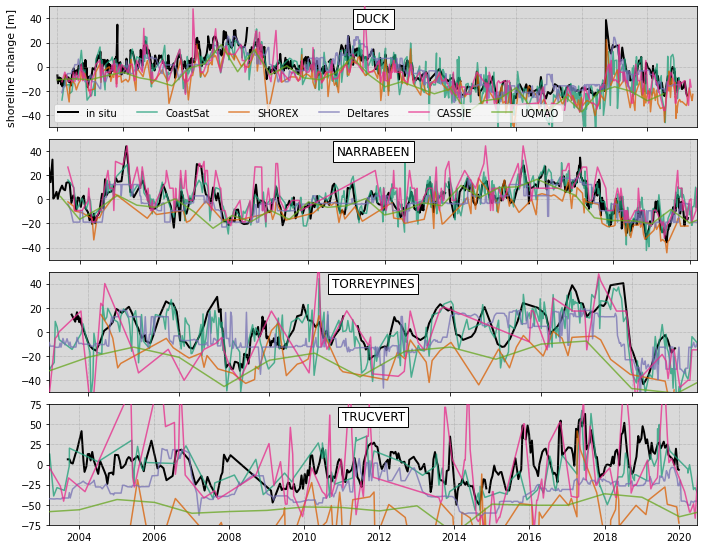

In [5]:
# selected transects (one per site) for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF8'],
    'DUCK':      ['1097'],
    'TRUCVERT':   ['-400',],
    'TORREYPINES':['PF525'],    
    }
# make figure
fig = plt.figure(figsize=[10,8], tight_layout=True)
gs = gridspec.GridSpec(4,1)
gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
# loop through sites
for i,sitename in enumerate(names_datasets[1:]):
    key = selected_transects[sitename][0]
    gt = sub_output[grountruth_type][sitename]
    
    ax = fig.add_subplot(gs[i,0])
    ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0)
    mean = np.nanmean(gt[key]['chainage'])
    
    # plot groundtruth
    ax.plot(gt[key]['dates'], gt[key]['chainage']-mean,'k-',lw=2,
            label='in situ',zorder=1)
    
    # loop through submissions
    for k,sub in enumerate(submissions):
        if key not in sub_output[sub][sitename].keys(): continue
        dates = sub_output[sub][sitename][key]['dates']
        chain = sub_output[sub][sitename][key]['chainage']
        # plot time-series
        ax.plot(dates, chain-mean, '-', lw=1.5, color=colours[k],
                alpha=0.75, label=sub.split('team_')[-1], zorder=1+k)
    # add label
    ax.text(0.5,0.95, sitename, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=12,zorder=10)
    # set axis limits
    ax.set_xlim([np.min(gt[key]['dates'])-timedelta(days=180),
                 np.max(gt[key]['dates'])+timedelta(days=180)])
    if sitename == 'NARRABEEN':
        ax.set_xlim([datetime(1986,6,1),
                     np.max(gt[key]['dates'])+timedelta(days=180)])
    ax.set_ylim(ylims)
    if sitename == 'TRUCVERT':
        ax.set_ylim(ylims*1.5)
    # add legend and ticks
    if i == 0: 
        ax.legend(loc='lower left',framealpha=0.75,ncol=6,
                  fontsize=10) 
        ax.set_ylabel('shoreline change [m]', fontsize=11)
    if not i == len(names_datasets[1:])-1:
        ax.set(xticklabels=[])
    ax.set_facecolor('0.85')

# save figure
# fig.savefig(os.path.join(eval_folder,'0_allsites_ts.jpg'),dpi=200)

#### 1.2. Plot the time-series for several transects at each site 

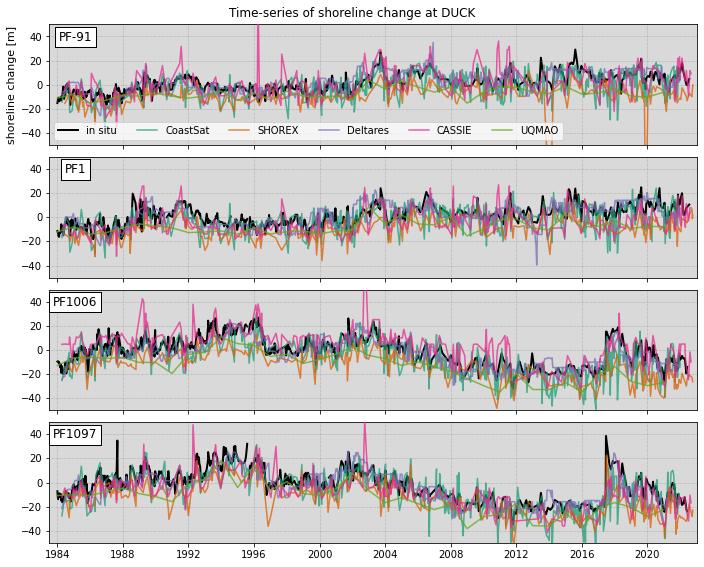

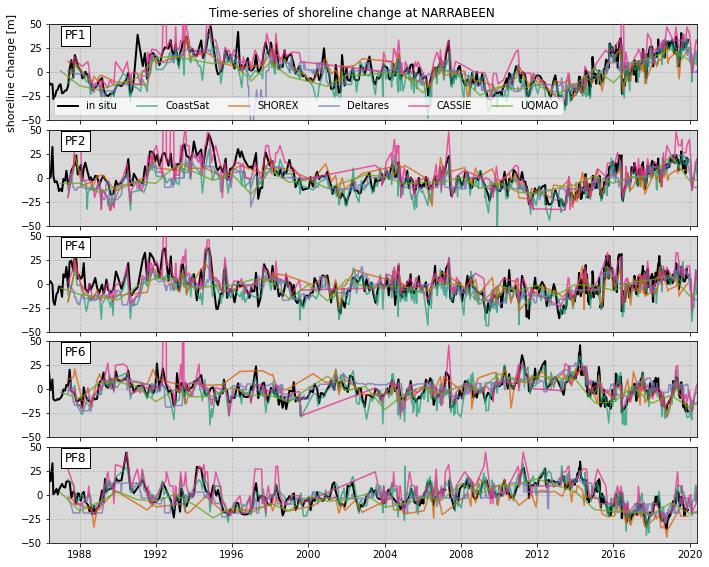

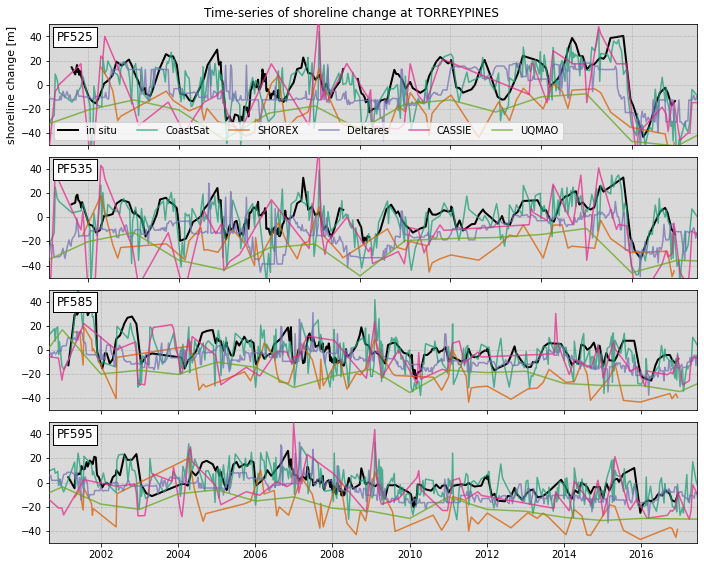

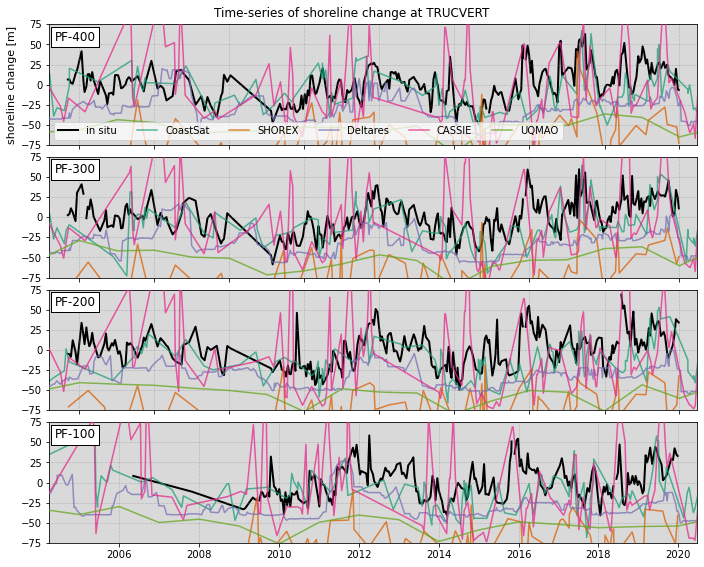

In [6]:
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# loop through sites
for sitename in names_datasets:
    if sitename == 'CALAMILLOR': continue
    transects = selected_transects[sitename]
    # make plot comparing the time-series
    fig = plt.figure(figsize=[10,8], tight_layout=True)
    fig.suptitle('Time-series of shoreline change at %s'%(sitename),fontsize=12)
    gs = gridspec.GridSpec(len(transects),1)
    gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
    # load groundtruth
    gt = sub_output[grountruth_type][sitename]
    # plot transects
    for i,key in enumerate(transects):
        ax = fig.add_subplot(gs[i,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0)
        mean = np.nanmean(gt[key]['chainage'])
        # plot groundtruth
        ax.plot(gt[key]['dates'], gt[key]['chainage']-mean,'k-',lw=2,
                label='in situ',zorder=1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            if key not in sub_output[sub][sitename].keys(): continue
            dates = sub_output[sub][sitename][key]['dates']
            chain = sub_output[sub][sitename][key]['chainage']
            # plot time-series
            ax.plot(dates, chain-mean, '-', lw=1.5, color=colours[k],
                    alpha=0.75, label=sub.split('team_')[-1], zorder=1+k)
            # add label
            tr_key = key
            if not 'PF' in key: tr_key = 'PF'+key
            ax.text(0.04,0.95, tr_key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                    va='top', transform=ax.transAxes, fontsize=12,zorder=10) 
            # set axis limits
            ax.set_xlim([np.min(gt[key]['dates'])-timedelta(days=180),
                         np.max(gt[key]['dates'])+timedelta(days=180)])
            if sitename == 'NARRABEEN':
                ax.set_xlim([datetime(1986,6,1),
                             np.max(gt[key]['dates'])+timedelta(days=180)])
            ax.set_ylim(ylims)
            if sitename == 'TRUCVERT':
                ax.set_ylim(ylims*1.5)
            # add legend and ticks
            if i == 0: 
                ax.legend(loc='lower left',framealpha=0.75,ncol=6,fontsize=10) 
                ax.set_ylabel('shoreline change [m]', fontsize=11)
            if not i == len(transects)-1:
                ax.set(xticklabels=[])
            ax.set_facecolor('0.85')
    # save one figure per site
    # fig.savefig(os.path.join(eval_folder,'1_%s_ts.jpg'%sitename),dpi=200)

### 2. Assess the accuracy of the shoreline time-series 

In the next few sections, we calculate error metrics for each submission by comparing the time-series to the groundtruth.

The user can select the transects over which to evaluate the time-series and a few parameters for the assessment:
- `min_days`: 3 days (default), number of days over which it can be assumed that the shoreline has not change. If a survey is located within this time window, it is compared directly to the satellite shorelines.
- `max_days`: 10 days (default), number of days after which a comparison is not realistic any more due to shoreline changes. Between `min_days` and `max_days`, the surveyed shoreline time-series are interpolated to match the date of the satellite shoreline points.

There are also 2 visualisation parameters, the `binwidth` to use when plotting the histogram distributions and the limits (`lims`) over which to plot the errors.

In [7]:
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }

#### 2.1. Compute horizontal errors and store in dictionary

In [9]:
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }

fn_output = os.path.join(fp_eval,'errors.pkl')
if not os.path.exists(fn_output):
    # initialise dict
    output_eval = {}
    # loop through sites
    for sitename in names_datasets:
        if sitename == 'CALAMILLOR': continue
        output_eval[sitename] = {}
        # get selected transects
        transects = selected_transects[sitename]
        # get groundtruth
        gt = sub_output[grountruth_type][sitename]
        # make plot comparing the time-series
        fig = plt.figure(figsize=[10,8], tight_layout=True)
        gs = gridspec.GridSpec(len(submissions),1)
        gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
        # loop through submissions
        for k,sub in enumerate(submissions):
                    
            # evaluate the time-series along each transect
            chain_sat_all, chain_sur_all, satnames_all = [], [], []
            for key in transects:
                if key not in sub_output[sub][sitename].keys(): continue
                if key not in gt.keys(): continue
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries(sub_output[sub][sitename][key],gt,key,settings);
                plt.close(_);
                chain_sat_all = np.append(chain_sat_all,ts_sat)
                chain_sur_all = np.append(chain_sur_all,ts_sur)
                satnames_all = satnames_all + satnames 
            
            # store matching points in dict
            output_eval[sitename][sub] = {'chain_sat':chain_sat_all,
                                          'chain_gt':chain_sur_all,
                                          'satnames':satnames_all}
            
            # calculate statistics for site
            chain_error = chain_sat_all - chain_sur_all
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all, chain_sat_all);
            R2 = rvalue**2
            rmse = np.sqrt(np.mean((chain_error)**2))
            mean = np.mean(chain_error)
            std = np.std(chain_error)
            q90 = np.percentile(np.abs(chain_error), 90)
            
            # store in dict
            output_eval[sitename][sub]['R2'] = R2
            output_eval[sitename][sub]['RMSE'] = rmse
            output_eval[sitename][sub]['Mean'] = mean
            output_eval[sitename][sub]['STD'] = std
            output_eval[sitename][sub]['q90'] = q90
    
    # save output_eval as pickle    
    with open(fn_output,'wb') as f:
        pickle.dump(output_eval,f)
    print('Generated errors dict...')              
else:
    # load output_eval pickle    
    with open(fn_output,'rb') as f:
        output_eval = pickle.load(f)  
    print('Loaded errors dict...')   

not enough data points for comparison at transect -100
Generated errors dict...


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

#### 2.2. Plot boxplots for each site and each submission

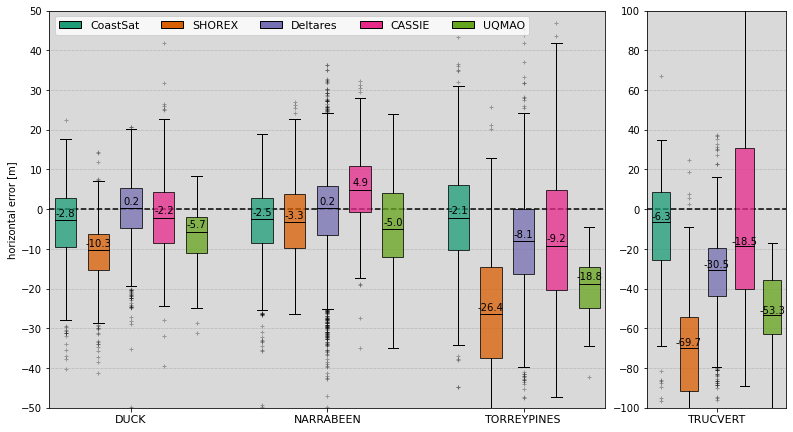

In [10]:
factor = 6
# make plot comparing the time-series
fig = plt.figure(figsize=[11.5,6.2], tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
gs.update(left=0.08, right=0.97, bottom=0.06, top=0.95, wspace=0.12)
# axis 1 for DUCK, NARRABEEN, TORREYPINES
ax1 = fig.add_subplot(gs[0])
ax1.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax1.set_facecolor('0.85')
ax1.axhline(y=0, ls='--', lw=1.5, color='k')
ax1.set(ylabel='horizontal error [m]', ylim=[-50,50]);
# axis 2 for TRUCVERT (different y-scale)
ax2 = fig.add_subplot(gs[1])
ax2.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax2.set_facecolor('0.85')
ax2.axhline(y=0, ls='--', lw=1.5, color='k')
ax2.set(ylim=[-100,100])
submissions_short = [_.split('team_')[-1] for _ in submissions]
# loop through sites
for i,sitename in enumerate(names_datasets):
    if sitename == 'CALAMILLOR': continue
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        if sitename == 'TRUCVERT': ax = ax2
        else: ax = ax1
        # compute errors
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # plot boxplot
        bp = ax.boxplot(chain_error,sym='+',positions=[(i)*factor+k],
                        widths=0.65,patch_artist=True,showfliers=True,
                        whiskerprops={'linewidth':1},
                        flierprops={'alpha':0.3,'markersize':4,
                                    'color':'0.5'})
        for median in bp['medians']:
            median.set(color='k', linewidth=1)
        for j,boxes in enumerate(bp['boxes']):
            boxes.set(facecolor=colours[k],alpha=0.75)
        # add median value as text
        ax.text((i)*factor+k,np.median(chain_error)+1,
                '%.1f'%np.median(chain_error),
                horizontalalignment='center', fontsize=10)
# add legend
handles = []
for k,sub in enumerate(submissions):
    handles.append(mpatches.Patch(color=colours[k],ec='k',label=submissions_short[k]))
ax1.legend(handles=handles, loc='upper left', ncol=5, fontsize=11);
# set xticklabels
ax1.set_xticks([(_)*factor+factor/2-1 for _ in range(1,len(names_datasets)-1)],labels=names_datasets[1:-1]);
ax1.set_xticklabels(names_datasets[1:-1],fontweight='normal',fontsize=11);
ax2.set_xticks([(_)*factor+factor/2-1 for _ in [4]],labels=[names_datasets[-1]]);
ax2.set_xticklabels([names_datasets[-1]],fontweight='normal',fontsize=11);
# set yticklabels
ax1.set_yticks(np.arange(-50,50+10,10));
ax2.set_yticks(np.arange(-100,100+20,20));
# save figure
# fig.savefig(os.path.join(eval_folder,'3_boxplots_selected.jpg'),dpi=200)

#### 2.3. Plot error distributions for each site

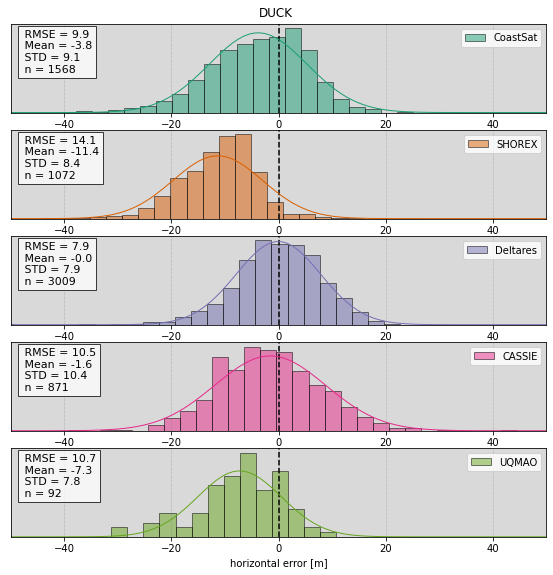

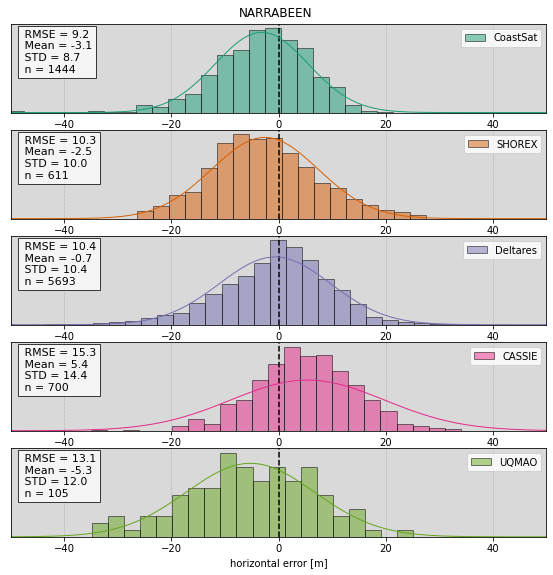

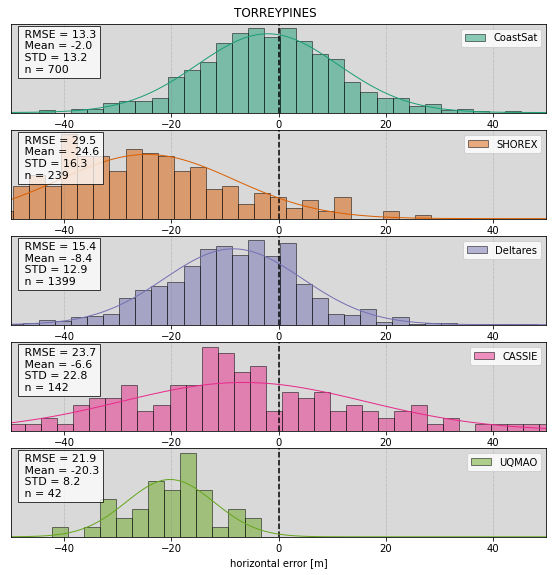

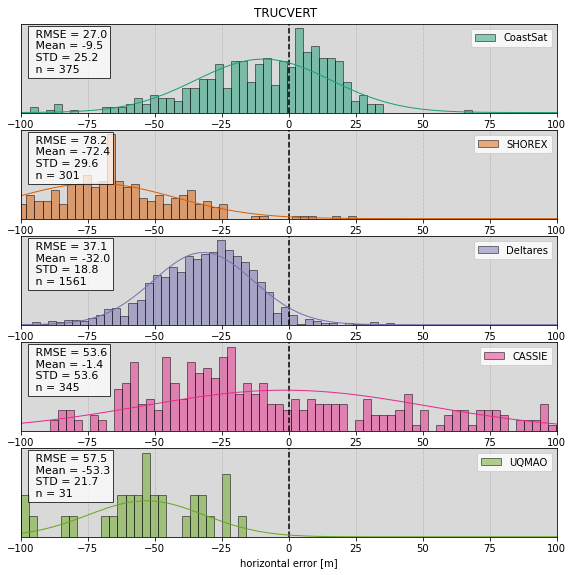

In [11]:
# loop through sites
for sitename in names_datasets:
    if sitename == 'CALAMILLOR': continue
    # make plot comparing the time-series
    fig = plt.figure(figsize=[8,8], tight_layout=True)
    gs = gridspec.GridSpec(len(submissions),1)
    gs.update(left=0.04, right=0.97, bottom=0.06, top=0.95, hspace=0.2)
    fig.suptitle('%s'%(sitename),fontsize=12)
    # loop through submissions
    for k,sub in enumerate(submissions):
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # get metrics
        R2 = output_eval[sitename][sub]['R2']
        rmse = output_eval[sitename][sub]['RMSE']
        mean = output_eval[sitename][sub]['Mean']
        std = output_eval[sitename][sub]['STD']
        q90 = output_eval[sitename][sub]['q90']
        # plot histogram
        ax = fig.add_subplot(gs[k,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0) 
        ax.axvline(x=0, ls='--', lw=1.5, color='k')
        binwidth = settings['binwidth']
        bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
        density = ax.hist(chain_error, bins=bins, density=True, color=colours[k],
                          edgecolor='k', alpha=0.5, label=sub.split('team_')[-1])
        mu, std = stats.norm.fit(chain_error)
        pval = stats.normaltest(chain_error)[1]
        xlims = settings['lims']
        if sitename == 'TRUCVERT': xlims = [-100,100]
        x = np.linspace(xlims[0], xlims[1], 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, '-',color=colours[k], linewidth=1)
        ax.set(xlabel='horizontal error [m]', xlim=xlims)
        str_stats = ' RMSE = %.1f\n Mean = %.1f\n STD = %.1f\n n = %d' % (rmse, mean, std, len(chain_error))
        ax.text(0.02, 0.94, str_stats,va='top', transform=ax.transAxes,fontsize=11,
                bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.75))
        ax.legend(loc='upper right')
        ax.set_yticks([])
        ax.set_facecolor('0.85')
    # save figure (one per site)
    # fig.savefig(os.path.join(eval_folder,'2_%s_histograms.jpg'%sitename),dpi=200)

## Appendix

Additional results

#### Repeat assessment but using all transects (with variable number of surveys)

In [ ]:
grountruth_type = 'groundtruth_MSL'
if not os.path.exists('submitted_errors_all.pkl'):
    # initialise dict
    output_eval = {}
    # loop through sites
    for sitename in names_datasets:
        if sitename == 'CALAMILLOR': continue
        output_eval[sitename] = {}
        # get selected transects
        transects = selected_transects[sitename]
        # get groundtruth
        gt = sub_output[grountruth_type][sitename]
        # test with all transects
        transects = list(gt.keys())
        # make plot comparing the time-series
        fig = plt.figure(figsize=[10,8], tight_layout=True)
        gs = gridspec.GridSpec(len(submissions),1)
        gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            # evaluate the time-series along each transect
            chain_sat_all, chain_sur_all, satnames_all = [], [], []
            for key in transects:
                if key not in sub_output[sub][sitename].keys(): continue
                if key not in gt.keys(): continue
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries(sub_output[sub][sitename][key],gt,key,settings)
                plt.close(_)
                chain_sat_all = np.append(chain_sat_all,ts_sat)
                chain_sur_all = np.append(chain_sur_all,ts_sur)
                satnames_all = satnames_all + satnames 
            
            # store matching points in dict
            output_eval[sitename][sub] = {'chain_sat':chain_sat_all,
                                          'chain_gt':chain_sur_all,
                                          'satnames':satnames_all}
            
            # calculate statistics for site
            chain_error = chain_sat_all - chain_sur_all
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all, chain_sat_all);
            R2 = rvalue**2
            rmse = np.sqrt(np.mean((chain_error)**2))
            mean = np.mean(chain_error)
            std = np.std(chain_error)
            q90 = np.percentile(np.abs(chain_error), 90)
            
            # store in dict
            output_eval[sitename][sub]['R2'] = R2
            output_eval[sitename][sub]['RMSE'] = rmse
            output_eval[sitename][sub]['Mean'] = mean
            output_eval[sitename][sub]['STD'] = std
            output_eval[sitename][sub]['q90'] = q90
    
    # save output_eval as pickle    
    with open('submitted_errors_all.pkl','wb') as f:
        pickle.dump(output_eval,f)
    print('Generated errors dict...')              
else:
    # load output_eval pickle    
    with open('submitted_errors_all.pkl','rb') as f:
        output_eval = pickle.load(f)  
    print('Loaded errors dict...') 

In [ ]:
factor = 6
# make plot comparing the time-series
fig = plt.figure(figsize=[11.5,6.2], tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
gs.update(left=0.08, right=0.97, bottom=0.06, top=0.95, wspace=0.12)
# axis 1 for DUCK, NARRABEEN, TORREYPINES
ax1 = fig.add_subplot(gs[0])
ax1.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax1.set_facecolor('0.85')
ax1.axhline(y=0, ls='--', lw=1.5, color='k')
ax1.set(ylabel='horizontal error [m]', ylim=[-50,50]);
# axis 2 for TRUCVERT (different y-scale)
ax2 = fig.add_subplot(gs[1])
ax2.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax2.set_facecolor('0.85')
ax2.axhline(y=0, ls='--', lw=1.5, color='k')
ax2.set(ylim=[-100,100])
submissions_short = [_.split('team_')[-1] for _ in submissions]
# loop through sites
for i,sitename in enumerate(names_datasets):
    if sitename == 'CALAMILLOR': continue
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        if sitename == 'TRUCVERT': ax = ax2
        else: ax = ax1
        # compute errors
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # plot boxplot
        bp = ax.boxplot(chain_error,sym='+',positions=[(i)*factor+k],
                        widths=0.65,patch_artist=True,showfliers=True,
                        whiskerprops={'linewidth':1},
                        flierprops={'alpha':0.3,'markersize':4,
                                    'color':'0.5'})
        for median in bp['medians']:
            median.set(color='k', linewidth=1)
        for j,boxes in enumerate(bp['boxes']):
            boxes.set(facecolor=colours[k],alpha=0.75)
        # add median value as text
        ax.text((i)*factor+k,np.median(chain_error)+1,
                '%.1f'%np.median(chain_error),
                horizontalalignment='center', fontsize=10)
# add legend
handles = []
for k,sub in enumerate(submissions):
    handles.append(mpatches.Patch(color=colours[k],ec='k',label=submissions_short[k]))
ax1.legend(handles=handles, loc='upper left', ncol=5, fontsize=11);
# set xticklabels
ax1.set_xticks([(_)*factor+factor/2-1 for _ in range(1,len(names_datasets)-1)],labels=names_datasets[1:-1]);
ax1.set_xticklabels(names_datasets[1:-1],fontweight='normal',fontsize=11);
ax2.set_xticks([(_)*factor+factor/2-1 for _ in [4]],labels=[names_datasets[-1]]);
ax2.set_xticklabels([names_datasets[-1]],fontweight='normal',fontsize=11);
# set yticklabels
ax1.set_yticks(np.arange(-50,50+10,10));
ax2.set_yticks(np.arange(-100,100+20,20));
# save figure
# fig.savefig(os.path.join(eval_folder,'3_boxplots_all.jpg'),dpi=200)

In [ ]:
# loop through sites
for sitename in names_datasets:
    if sitename == 'CALAMILLOR': continue
    # make plot comparing the time-series
    fig = plt.figure(figsize=[8,8], tight_layout=True)
    gs = gridspec.GridSpec(len(submissions),1)
    gs.update(left=0.04, right=0.97, bottom=0.06, top=0.95, hspace=0.2)
    fig.suptitle('%s'%(sitename),fontsize=12)
    # loop through submissions
    for k,sub in enumerate(submissions):
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # get metrics
        R2 = output_eval[sitename][sub]['R2']
        rmse = output_eval[sitename][sub]['RMSE']
        mean = output_eval[sitename][sub]['Mean']
        std = output_eval[sitename][sub]['STD']
        q90 = output_eval[sitename][sub]['q90']
        # plot histogram
        ax = fig.add_subplot(gs[k,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0) 
        ax.axvline(x=0, ls='--', lw=1.5, color='k')
        binwidth = settings['binwidth']
        bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
        density = ax.hist(chain_error, bins=bins, density=True, color=colours[k],
                          edgecolor='k', alpha=0.5, label=sub.split('team_')[-1])
        mu, std = stats.norm.fit(chain_error)
        pval = stats.normaltest(chain_error)[1]
        xlims = settings['lims']
        if sitename == 'TRUCVERT': xlims = [-100,100]
        x = np.linspace(xlims[0], xlims[1], 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, '-',color=colours[k], linewidth=1)
        ax.set(xlabel='horizontal error [m]', xlim=xlims)
        str_stats = ' RMSE = %.1f\n Mean = %.1f\n STD = %.1f\n n = %d' % (rmse, mean, std, len(chain_error))
        ax.text(0.02, 0.94, str_stats,va='top', transform=ax.transAxes,fontsize=11,
                bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.75))
        ax.legend(loc='upper right')
        ax.set_yticks([])
        ax.set_facecolor('0.85')

#### Comare time-series to groundtruth individually for each submission

In [ ]:
grountruth_type = 'groundtruth_MSL'
# load formatted submissions
with open('submitted_timeseries.pkl','rb') as f:
    sub_output = pickle.load(f)
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }
ylims = settings['lims']
# loop through submissions
for sub in submissions:
    fig = plt.figure(figsize=[18,0.5], tight_layout=True)
    plt.title(sub,fontsize=20,fontweight='bold')
    plt.axis('off')
    # loop through sites
    for sitename in names_datasets:
        # skip site if it wasn't mapped
        if sitename not in submission_sites: continue
        if sitename == 'TRUCVERT': settings['lims'] = [-150,150]
        else: settings['lims'] = ylims
        transects = selected_transects[sitename]
        # load groundtruth
        gt = sub_output[grountruth_type][sitename]
        transects = selected_transects[sitename]
        fig = plt.figure(figsize=[18,0.5], tight_layout=True)
        plt.title(sitename,fontsize=20,fontweight='bold')
        plt.axis('off')
        for key in transects:
            if key not in sub_output[sub][sitename].keys(): continue
            ts_sat, ts_sur, satnames, fig = utils.compare_timeseries(sub_output[sub][sitename][key],gt,key,settings)
            # fig.savefig(os.path.join(site_folder,'%s_transect_%s.jpg'%(sitename,key)), dpi=200)